In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
# convolutional layer 1.
filter_size1 = 5  # convolution filters are 5x5 pixels
num_filters1 = 16 # there are 16 filters
# convolutional layer 2.
filter_size2 = 5 # convolution filters are 5X5 pixels
num_filters2 = 36 # there are 36 filters
# fully-connected layer
fc_size = 128 # number of neurons in fully-connected layer

In [3]:
# load MNIST data
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
print(data.test.labels.shape)
data.test.cls = np.argmax(data.test.labels, axis=1)
print(data.test.cls.shape)

(10000, 10)
(10000,)


In [6]:
# data dimensional
ima_size = 28 # each dimensional has 28 pixels
# images are stored in one-dimensional arrays 
ima_size_flate = ima_size ** 2
ima_shape = (ima_size, ima_size)
num_channels = 1 # 1 channel for gray-scale
# number of clasees, one class for each of 10 digits
num_classes = 10

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    print(axes.flat)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(ima_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        # set xlabel, remove xticks, yticks
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

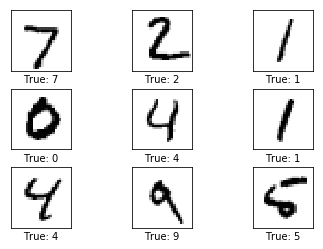

In [8]:
# plot test images
images = data.test.images[:9] # take the first 9 images from test data
cls_true = data.test.cls[:9] # take the first 9 images labels
plot_images(images=images, cls_true=cls_true)

In [9]:
def new_weights(shape):
    # tf.truncated_normal will create normal distribution random dataes
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [20]:
# create new convolutional layer
def new_conv_layer(input,                # the previous layer
                   num_input_channels,   # Num. channels in prev. layer
                   filter_size,          # weight and height of each filter
                   num_filters,          # Num. of filters
                   use_pooling=True):    # use 2x2 max-pooling
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    # create new weights correspond filters with the given shape.
    weights = new_weights(shape=shape)
    # create new  biases, one for each filter
    biases = new_biases(length=num_filters)
    # create the TF operation for convolution.
    # Note the strides are set to 1 in all dimensions
    # because the first is for the image-number and
    # the last is for the input-channel.
    # e.g.strides=[1, 2, 2, 1]would mean that the filter 
    # is moved 2 pixels across the x- and y- axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeros so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    # add the biases to the results of the convolution.
    # A bias-value is added to each filter layer.
    layer += biases
    
    if use_pooling:
        # This is 2x2 max-pooling, which means that we 
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],padding='SAME')
    # rectified linear unit (ReLU)
    # It calcuates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows
    # us to learn more complicatied functions.
    layer = tf.nn.relu(layer)
    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.
    
    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [21]:
def flatten_layer(layer):
    '''
    the convolution layer will return 4-D tensor, we will
    add a full connected layer,so we need to convert this 
    4-D tensor to 2-D tensor for full connected layer.
    '''
    # get the shape of the input layer
    layer_shape = layer.get_shape() # tensor.get_shape() return a tuple
    # The shape of the input layer is assumed to be:
    # layer_shape = [num_images, ima-height, ima_width, num_channels]
    # The number of features is: ima_height*ima_width*num_channels
    # we can use a function from TF to calculate this.
    num_features = layer_shape[1:].num_elements()
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated 
    # so the total size of the tensor is unchanged from the reshapeing.
    layer_flat = tf.reshape(layer, [-1, num_features])
    # The shape of the flatted layer is now:
    # [num_images, ima_height*ima_width*num_channels]
    return layer_flat, num_features

In [32]:
def new_fc_layer(input,        # the previous layer
                 num_inputs,   # Num. inputs from prev. layer
                 num_outputs,  # Num. outputs
                 use_relu=True): # use relu
    # create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    # calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [33]:
x = tf.placeholder(tf.float32, shape=[None, ima_size_flate], name='x')
# for convolution layer, we hope reshape x to 4-D tensor
x_image = tf.reshape(x, [-1, ima_size, ima_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [34]:
# create the first convelution layer
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [35]:
layer_conv1

<tf.Tensor 'Relu_2:0' shape=(?, 14, 14, 16) dtype=float32>

In [36]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [37]:
layer_conv2

<tf.Tensor 'Relu_3:0' shape=(?, 7, 7, 36) dtype=float32>

In [38]:
layer_flat, num_features = flatten_layer(layer_conv2)
print(layer_flat)
print(num_features)

Tensor("Reshape_6:0", shape=(?, 1764), dtype=float32)
1764


In [39]:
# add full connnected layer
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [40]:
layer_fc1

<tf.Tensor 'Relu_4:0' shape=(?, 128) dtype=float32>

In [42]:
# add the second full connected layer
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [43]:
layer_fc2

<tf.Tensor 'add_7:0' shape=(?, 10) dtype=float32>

In [44]:
# normalize
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [46]:
# the loss function
# cross entropy for every image under current model
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
# the mean cross entropy of all images under current model
cost = tf.reduce_mean(cross_entropy)

In [47]:
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [48]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [49]:
# create session
session = tf.Session()
# initialize the variables
session.run(tf.global_variables_initializer())

In [54]:
train_batch_size = 64
# counter for total number of iterations performed so far
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations+num_iterations):
        # get a batch of training examples
        # a_batch holds a batch of images and
        # y_true_batch holds the true labels for these images
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        # put the batch into a dict with the proper names
        # for placeholder variables in the TF graph
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        # run the optimizer using this batch of training data
        # TF assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        # print status every 100 iterations
        if i % 100 == 0:
            # calculate the accuracy on the training data
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            msg = "Optimization Iteration: {0:>6}, Training Accuracy:{1:>6.1%}"
            print(msg.format(i+1, acc))
    # update the total number of iterations
    total_iterations += num_iterations
    
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage:" + str(timedelta(seconds=int(round(time_dif)))))
       

In [55]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [56]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  7.8%
Time usage:0:00:00


In [57]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy: 67.2%
Optimization Iteration:    201, Training Accuracy: 89.1%
Optimization Iteration:    301, Training Accuracy: 90.6%
Optimization Iteration:    401, Training Accuracy: 89.1%
Optimization Iteration:    501, Training Accuracy: 92.2%
Optimization Iteration:    601, Training Accuracy: 96.9%
Optimization Iteration:    701, Training Accuracy: 87.5%
Optimization Iteration:    801, Training Accuracy: 87.5%
Optimization Iteration:    901, Training Accuracy: 96.9%
Time usage:0:00:28


In [71]:
test_batch_szie = 256
def print_test_accuracy(show_examples_errors=False,
                        show_confusion_matrix=False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0
    while i < num_test:
        j = min(i+test_batch_szie, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
        
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    
    msg = "Accuracy on Test-set: {0:.1%} ({1}/{2})"
    print(msg.format(acc, correct_sum, num_test))
    if show_examples_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

Accuracy on Test-set: 93.5% (9347/10000)
Example errors:


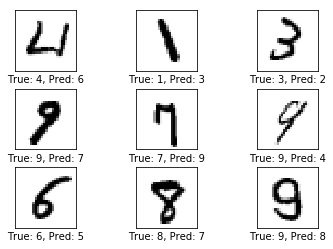

In [72]:
print_test_accuracy(show_examples_errors=True)

In [73]:
optimize(num_iterations=9000)

Optimization Iteration:   1001, Training Accuracy: 93.8%
Optimization Iteration:   1101, Training Accuracy: 92.2%
Optimization Iteration:   1201, Training Accuracy: 98.4%
Optimization Iteration:   1301, Training Accuracy: 92.2%
Optimization Iteration:   1401, Training Accuracy: 95.3%
Optimization Iteration:   1501, Training Accuracy: 98.4%
Optimization Iteration:   1601, Training Accuracy: 96.9%
Optimization Iteration:   1701, Training Accuracy: 96.9%
Optimization Iteration:   1801, Training Accuracy: 95.3%
Optimization Iteration:   1901, Training Accuracy: 93.8%
Optimization Iteration:   2001, Training Accuracy: 96.9%
Optimization Iteration:   2101, Training Accuracy: 95.3%
Optimization Iteration:   2201, Training Accuracy: 93.8%
Optimization Iteration:   2301, Training Accuracy: 98.4%
Optimization Iteration:   2401, Training Accuracy: 98.4%
Optimization Iteration:   2501, Training Accuracy:100.0%
Optimization Iteration:   2601, Training Accuracy:100.0%
Optimization Iteration:   2701,

Accuracy on Test-set: 98.8% (9881/10000)
Example errors:


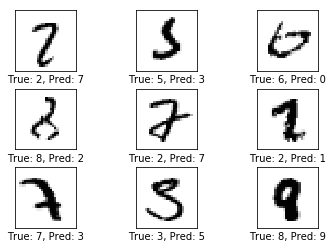

In [74]:
print_test_accuracy(show_examples_errors=True)